Data Downloading 

In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  8640k      0  0:00:09  0:00:09 --:--:-- 15.5M


data preparing 

integer sequence datasets preparing 

A model built on one-hot encoded vector sequences

Training a basic model

Found 15000 files belonging to 2 classes.
Using 12000 files for training.
Found 15000 files belonging to 2 classes.
Using 3000 files for validation.
Found 25000 files belonging to 2 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 10000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               2568448   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
  

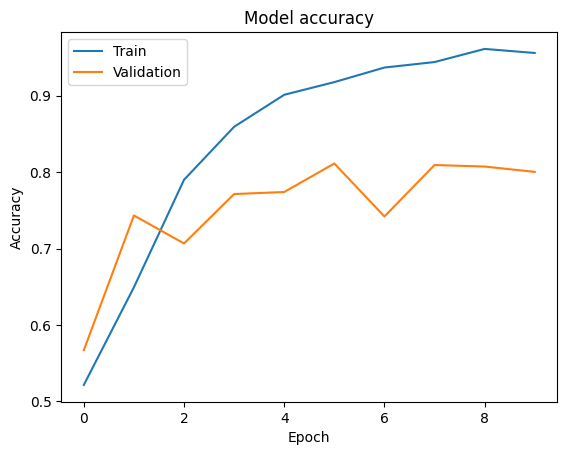

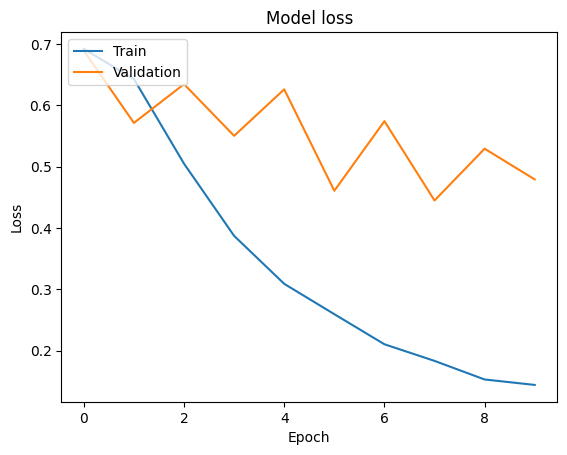

In [2]:
import os, pathlib, shutil, random
from tensorflow import keras

batch_size = 32
max_length = 150
max_tokens = 10000
num_train_samples = 100
num_val_samples = 10000

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples_cat = int(num_val_samples/2)
    val_files = files[-num_val_samples_cat:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=1337)

train_ds = train_ds.take(num_train_samples)

val_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=1337)

val_ds = val_ds.take(num_val_samples)

test_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)

text_only_train_ds = train_ds.map(lambda x, y: x)

from tensorflow.keras import layers

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y),
                            num_parallel_calls=4)

int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y),
                        num_parallel_calls=4)

int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y),
                          num_parallel_calls=4)

import tensorflow as tf

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras", save_best_only=True)
]




history = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=callbacks
)

model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



Instantiating an layer

Model that uses an Embedding layer trained from scratch

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         2560000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
_________________________________________________

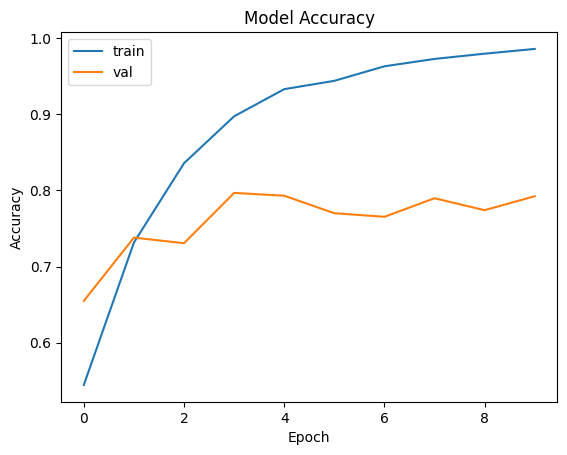

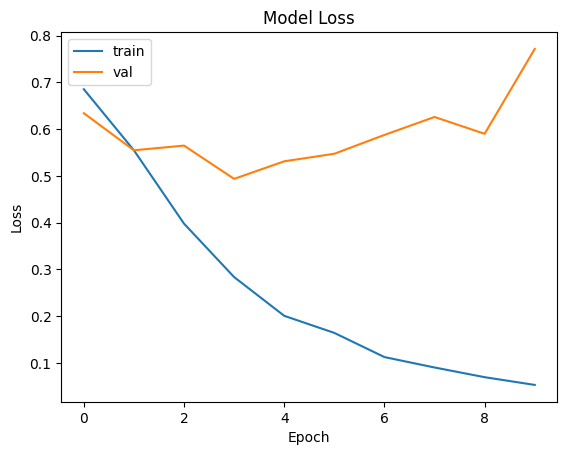

In [3]:
import matplotlib.pyplot as plt

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]

history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


Model 3 - An Embedding Layer with Masking enabled

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
_________________________________________________

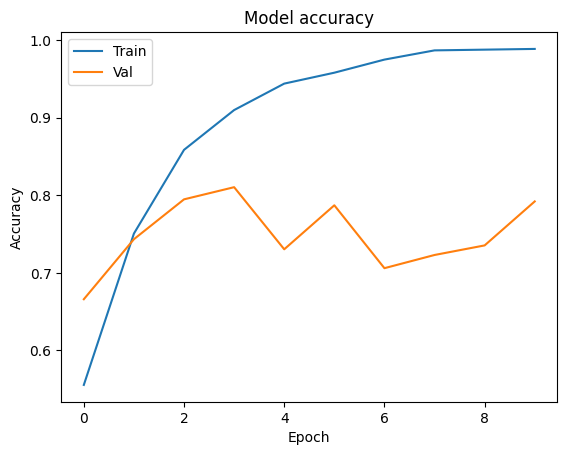

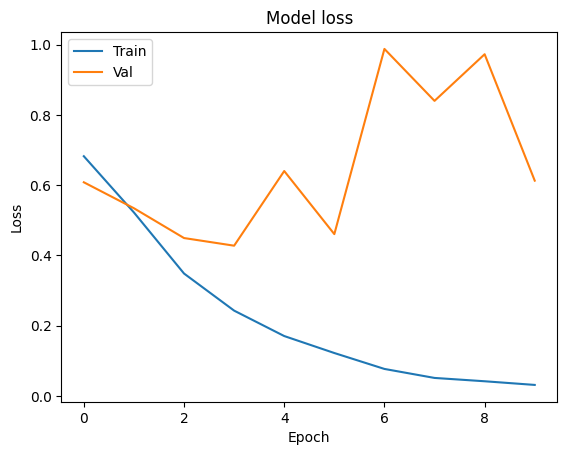

In [4]:
import matplotlib.pyplot as plt

# Define the model architecture
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

# Define the callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True),
    keras.callbacks.History()
]

# Train the model
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

# Load the best model
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

# Plot the training and validation accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


Model 4 - Using Pretrained word embedding

--2023-04-24 07:41:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-24 07:41:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-24 07:41:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

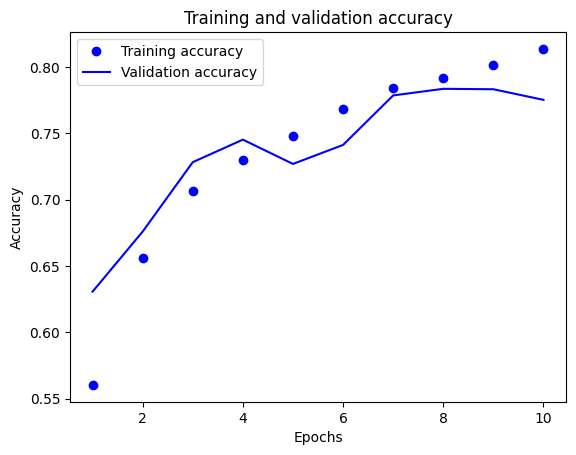

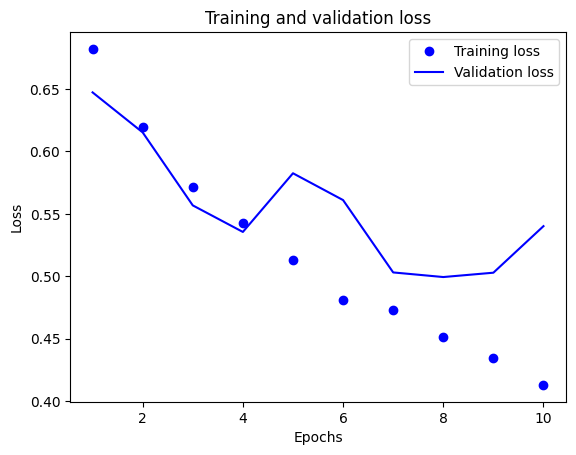

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

embedding_dim = 100
max_tokens = 10000
max_len = 150
num_samples = 100
validation_samples = 10000

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
word_index = {k: v for k, v in word_index.items() if v < max_tokens}

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]


history = model.fit(int_train_ds.take(num_samples).cache(),
          validation_data=int_val_ds.take(validation_samples).cache(),
          epochs=10, callbacks=callbacks)

model = keras.models.load_model("glove_embeddings_sequence_model.keras")
_, test_acc = model.evaluate(int_test_ds.take(validation_samples))
print(f"Test acc: {test_acc:.3f}")

# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Using different training samples for the embedding layer

Found 25000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 [==============================] - 23s 122ms/step - loss: 0.6729 - accuracy: 0.5677 - val_loss: 0.5657 - val_accuracy: 0.7140
Epoch 2/10
125/125 [==============================] - 10s 79ms/step - loss: 0.4912 - accuracy: 0.7690 - val_loss: 0.4201 - val_accuracy: 0.8170
Epoch 3/10
125/125 [==============================] - 7s 52ms/step - loss: 0.3349 - accuracy: 0.8698 - val_loss: 0.3885 - val_accuracy: 0.8270
Epoch 4/10
125/125 [==============================] - 5s 41ms/step - loss: 0.2243 - accuracy: 0.9183 - val_loss: 0.5619 - val_accuracy: 0.7620
Epoch 5/10
125/125 [==============================] - 4s 33ms/step - loss: 0.1541 - accuracy: 0.9490 - val_loss: 0.6495 - val_accuracy: 0.7640
Epoch 6/10
125/125 [==

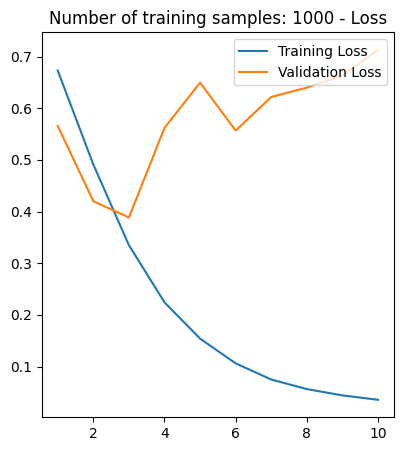

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 [==============================] - 24s 123ms/step - loss: 0.6678 - accuracy: 0.5832 - val_loss: 0.5581 - val_accuracy: 0.7150
Epoch 2/10
125/125 [==============================] - 10s 77ms/step - loss: 0.4828 - accuracy: 0.7730 - val_loss: 0.4256 - val_accuracy: 0.8090
Epoch 3/10
125/125 [==============================] - 6s 51ms/step - loss: 0.3344 - accuracy: 0.8692 - val_loss: 0.5488 - val_accuracy: 0.7760
Epoch 4/10
125/125 [==============================] - 4s 33ms/step - loss: 0.2257 - accuracy: 0.9140 - val_loss: 0.4976 - val_accuracy: 0.8210
Epoch 5/10
125/125 [==============================] - 5s 38ms/step - loss: 0.1665 - accuracy: 0.9425 - val_loss: 0.7070 - val_accuracy: 0.7650
Epoch 6/10
125/125 [==============================] - 3s 26ms/step - loss: 0.1141 - accuracy: 0.9622 - val_loss: 0.5665 - val_accuracy: 

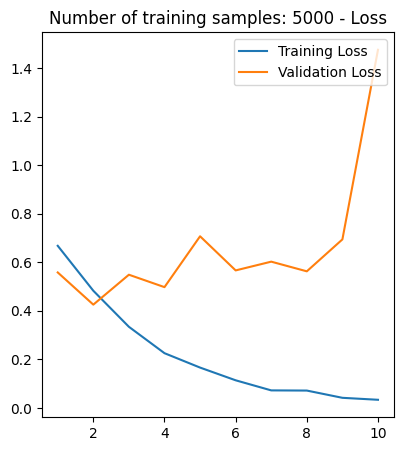

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 [==============================] - 23s 129ms/step - loss: 0.6839 - accuracy: 0.5630 - val_loss: 0.6332 - val_accuracy: 0.6380
Epoch 2/10
125/125 [==============================] - 10s 78ms/step - loss: 0.5121 - accuracy: 0.7485 - val_loss: 0.4444 - val_accuracy: 0.8000
Epoch 3/10
125/125 [==============================] - 6s 45ms/step - loss: 0.3391 - accuracy: 0.8637 - val_loss: 0.4076 - val_accuracy: 0.8080
Epoch 4/10
125/125 [==============================] - 4s 35ms/step - loss: 0.2157 - accuracy: 0.9143 - val_loss: 0.4383 - val_accuracy: 0.8400
Epoch 5/10
125/125 [==============================] - 5s 38ms/step - loss: 0.1450 - accuracy: 0.9538 - val_loss: 0.5240 - val_accuracy: 0.8000
Epoch 6/10
125/125 [==============================] - 3s 26ms/step - loss: 0.0998 - accuracy: 0.9675 - val_loss: 0.5520 - val_accuracy: 

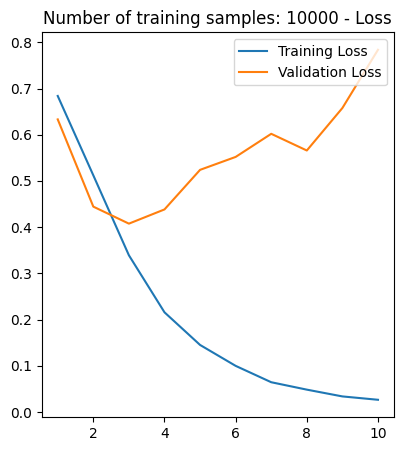

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 [==============================] - 24s 128ms/step - loss: 0.6654 - accuracy: 0.5835 - val_loss: 0.5633 - val_accuracy: 0.7000
Epoch 2/10
125/125 [==============================] - 9s 73ms/step - loss: 0.4821 - accuracy: 0.7818 - val_loss: 0.4101 - val_accuracy: 0.8220
Epoch 3/10
125/125 [==============================] - 6s 49ms/step - loss: 0.3279 - accuracy: 0.8705 - val_loss: 0.3918 - val_accuracy: 0.8320
Epoch 4/10
125/125 [==============================] - 4s 34ms/step - loss: 0.2209 - accuracy: 0.9175 - val_loss: 0.4660 - val_accuracy: 0.8060
Epoch 5/10
125/125 [==============================] - 5s 39ms/step - loss: 0.1583 - accuracy: 0.9435 - val_loss: 0.5908 - val_accuracy: 0.7860
Epoch 6/10
125/125 [==============================] - 3s 26ms/step - loss: 0.1102 - accuracy: 0.9607 - val_loss: 0.4859 - val_accuracy: 0

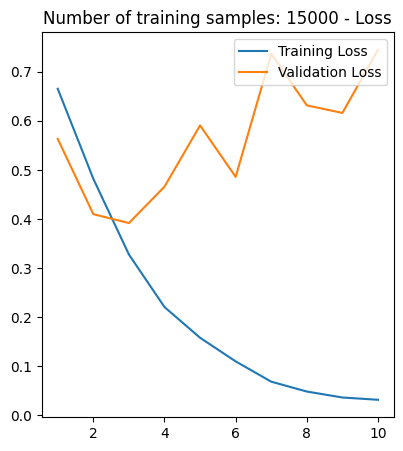

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 [==============================] - 24s 127ms/step - loss: 0.6748 - accuracy: 0.5745 - val_loss: 0.5762 - val_accuracy: 0.7050
Epoch 2/10
125/125 [==============================] - 10s 78ms/step - loss: 0.4808 - accuracy: 0.7797 - val_loss: 0.4201 - val_accuracy: 0.8180
Epoch 3/10
125/125 [==============================] - 6s 48ms/step - loss: 0.3316 - accuracy: 0.8692 - val_loss: 0.4006 - val_accuracy: 0.8290
Epoch 4/10
125/125 [==============================] - 4s 35ms/step - loss: 0.2173 - accuracy: 0.9233 - val_loss: 0.5510 - val_accuracy: 0.7950
Epoch 5/10
125/125 [==============================] - 4s 33ms/step - loss: 0.1492 - accuracy: 0.9492 - val_loss: 0.4777 - val_accuracy: 0.8160
Epoch 6/10
125/125 [==============================] - 3s 27ms/step - loss: 0.1031 - accuracy: 0.9653 - val_loss: 0.5761 - val_accuracy: 

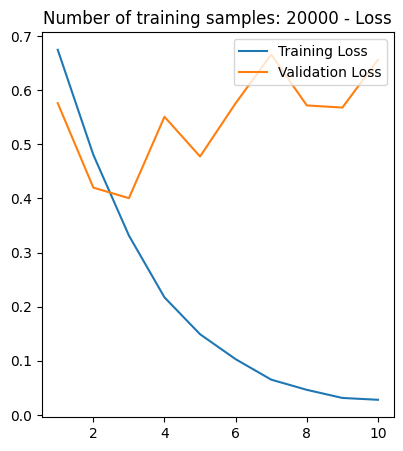

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 [==============================] - 24s 123ms/step - loss: 0.6816 - accuracy: 0.5600 - val_loss: 0.6163 - val_accuracy: 0.6580
Epoch 2/10
125/125 [==============================] - 10s 80ms/step - loss: 0.5052 - accuracy: 0.7588 - val_loss: 0.4400 - val_accuracy: 0.8090
Epoch 3/10
125/125 [==============================] - 6s 51ms/step - loss: 0.3455 - accuracy: 0.8585 - val_loss: 0.4011 - val_accuracy: 0.8210
Epoch 4/10
125/125 [==============================] - 4s 35ms/step - loss: 0.2277 - accuracy: 0.9140 - val_loss: 0.3976 - val_accuracy: 0.8340
Epoch 5/10
125/125 [==============================] - 5s 38ms/step - loss: 0.1609 - accuracy: 0.9448 - val_loss: 0.4839 - val_accuracy: 0.8100
Epoch 6/10
125/125 [==============================] - 4s 28ms/step - loss: 0.1033 - accuracy: 0.9657 - val_loss: 0.5673 - val_accuracy: 

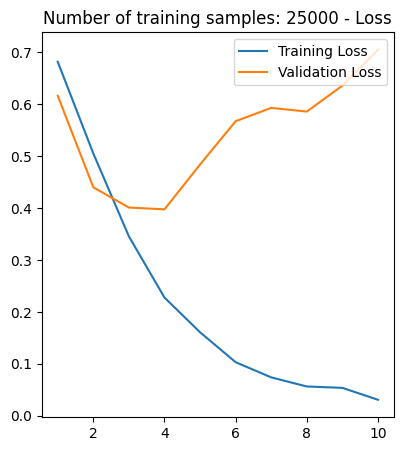

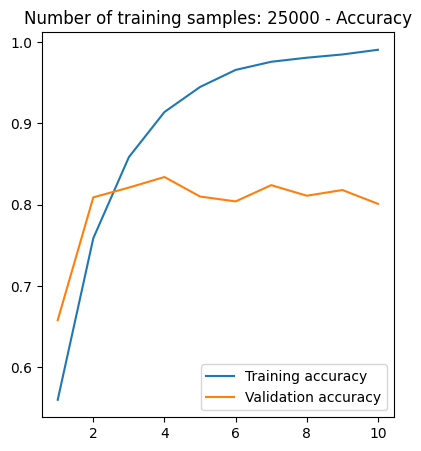

In [6]:
import os, pathlib, shutil, random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 32
max_length = 150
max_tokens = 10000
num_val_samples = 10000

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples_cat = int(num_val_samples/2)
    val_files = files[-num_val_samples_cat:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

test_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)

text_only_train_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=1337).map(lambda x, y: x)

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

text_vectorization.adapt(text_only_train_ds)

for num_train_samples in [1000, 5000, 10000, 15000, 20000, 25000]:
    train_ds = keras.preprocessing.text_dataset_from_directory(
        "aclImdb/train",
        batch_size=batch_size,
        validation_split=0.2,
        subset='training',
        seed=1337
    ).take(num_train_samples)

    val_ds = keras.preprocessing.text_dataset_from_directory(
        "aclImdb/train",
        batch_size=batch_size,
        validation_split=0.2,
        subset='validation',
        seed=1337
    ).take(num_val_samples)

    int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
    int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
    int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = layers.Embedding(
        input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint(f"embeddings_bidir_gru_with_masking_{num_train_samples}.keras",
                                        save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

    model = keras.models.load_model(f"embeddings_bidir_gru_with_masking_{num_train_samples}.keras")
    test_acc = model.evaluate(int_test_ds)[1]
    print(f"Number of training samples: {num_train_samples} - Test accuracy: {test_acc:.3f}")
    
 

    # Plot the training and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Number of training samples: {num_train_samples} - Loss')

    plt.show()

#Plot the training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(acc) + 1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training accuracy')
plt.plot(epochs_range, val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title(f'Number of training samples: {num_train_samples} - Accuracy')
plt.show()


